<a href="https://colab.research.google.com/github/Barclaysdev2011/data_science/blob/main/ChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%html
<style>
table {float:left}
</style>

In [ ]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.

  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1


In [ ]:
import boto3
import sagemaker
import datetime as dt
import pandas as pderparameterTuner
!pip install boto3 pandas openpyxl

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
default_bucket = "sagemaker-us-east-2-971422683094"
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

In [ ]:
import pandas as pd
import numpy as np
def preprocess_data(file_path):
    df =pd.read_excel(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

storedata = preprocess_data(f"s3://{default_bucket}/storedata_total.xlsx")

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [ ]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

In [ ]:
feature_names,train,validation,test = split_datasets(storedata)

In [ ]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

In [ ]:
from sagemaker.inputs import TrainingInput
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",content_type="csv")

In [ ]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [ ]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

In [ ]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [ ]:
objective_metric_name = "validation:auc"

In [ ]:
tuner = HyperparameterTuner(
    estimator,objective_metric_name,hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [ ]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................!


In [ ]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [ ]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [ ]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 11, 17, 6, 31, 15, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9798719882965088},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 11, 17, 6, 31, 53, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:971422683094:training-job/sagemaker-xgboost-241117-0627-005-a472f81c',
 'TrainingJobName': 'sagemaker-xgboost-241117-0627-005-a472f81c',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 11, 17, 6, 31, 19, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.8464510743767344',
                          'eta': '0.10396473372932413',
                          'max_depth': '5',
                          'min_child_weight': '5.792205967745163'}}


In [ ]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [ ]:
best_hyperparameters

{'alpha': '1.8464510743767344',
 'eta': '0.10396473372932413',
 'max_depth': '5',
 'min_child_weight': '5.792205967745163'}

In [ ]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [ ]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [ ]:
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [ ]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-11-17-06-35-01-675


In [ ]:
import time
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress


In [ ]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:971422683094:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-7a4f37fe',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 11, 17, 6, 37, 47, 190000, tzinfo=tzlocal())}]

In [ ]:
!pip show protobuf





Name: protobuf
Version: 3.20.3
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: 
Author-email: 
License: BSD-3-Clause
Location: /opt/conda/lib/python3.11/site-packages
Requires: 
Required-by: mlflow-skinny, sagemaker, smdebug


In [ ]:
!pip install protobuf==3.19.1

  Using cached protobuf-3.19.1-py2.py3-none-any.whl.metadata (807 bytes)
Using cached protobuf-3.19.1-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
smdebug 1.0.34 requires protobuf<=3.20.3,>=3.20.0, but you have protobuf 3.19.1 which is incompatible.


In [ ]:

import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
from smdebug.trials import create_trial


[2024-11-17 06:38:07.251 sagemaker-data-scienc-ml-t3-medium-7c351176d774b33936908a0c0aa0:1323 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [ ]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-11-17 06:39:19.125 sagemaker-data-scienc-ml-t3-medium-7c351176d774b33936908a0c0aa0:1323 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-971422683094/debugger/demo-smdebug-xgboost-churn-classificati-2024-11-17-06-35-01-675/debug-output


In [ ]:
trial.tensor_names()

[2024-11-17 06:39:28.427 sagemaker-data-scienc-ml-t3-medium-7c351176d774b33936908a0c0aa0:1323 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-17 06:39:29.442 sagemaker-data-scienc-ml-t3-medium-7c351176d774b33936908a0c0aa0:1323 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [ ]:
trial.tensor("average_shap/f1").values()

{0: array([-0.0001205], dtype=float32),
 5: array([-0.00074999], dtype=float32),
 10: array([0.00419655], dtype=float32),
 15: array([0.01009317], dtype=float32),
 20: array([0.01427092], dtype=float32),
 25: array([0.02715595], dtype=float32),
 30: array([0.03301489], dtype=float32),
 35: array([0.03339985], dtype=float32),
 40: array([0.03640737], dtype=float32),
 45: array([0.04403068], dtype=float32),
 50: array([0.04928932], dtype=float32),
 55: array([0.05976595], dtype=float32),
 60: array([0.06903414], dtype=float32),
 65: array([0.07380769], dtype=float32),
 70: array([0.08396588], dtype=float32),
 75: array([0.08599815], dtype=float32),
 80: array([0.09453048], dtype=float32),
 85: array([0.09545846], dtype=float32),
 90: array([0.09803019], dtype=float32),
 95: array([0.10296456], dtype=float32)}

In [ ]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

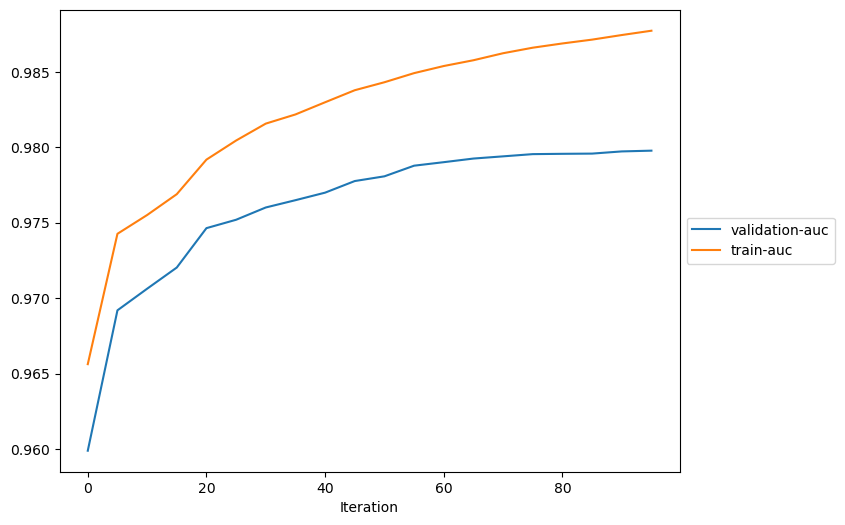

In [ ]:
import matplotlib.pyplot as plt
import re
from itertools import islice
plot_collection(trial, "metrics")

In [ ]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

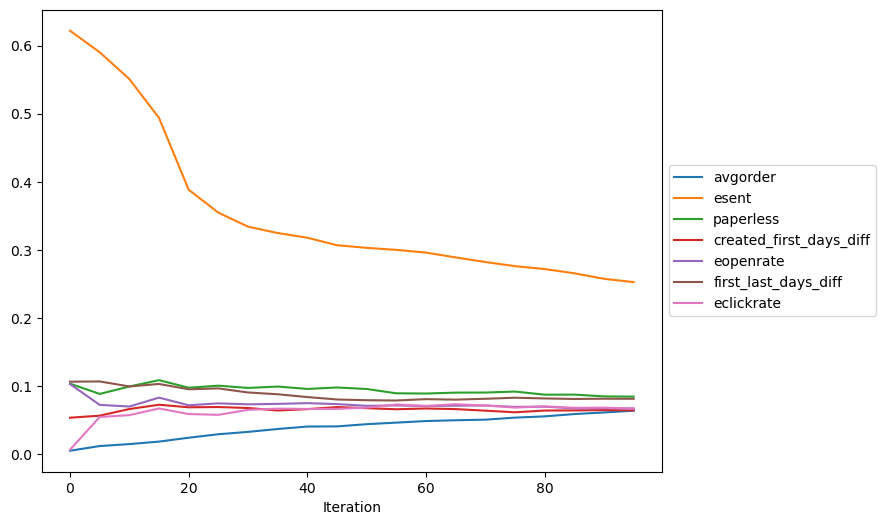

In [ ]:
plot_feature_importance(trial, importance_type="cover")

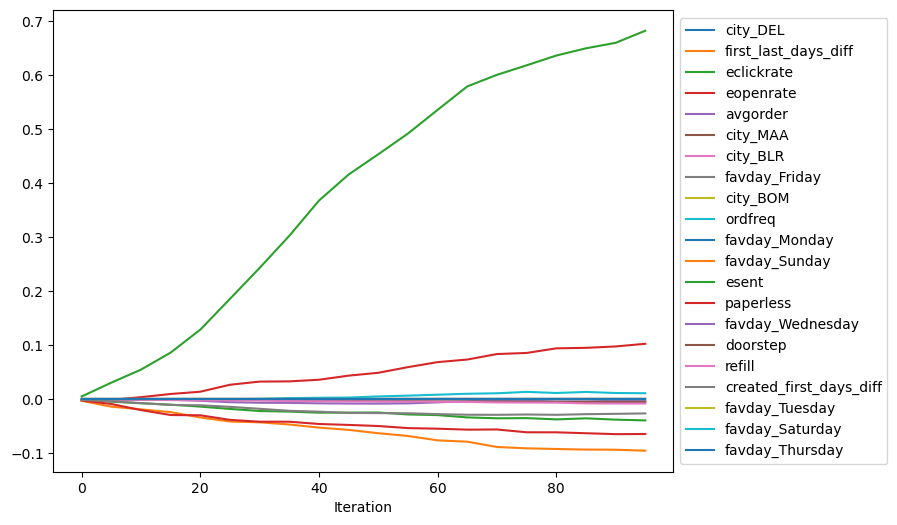

In [ ]:
plot_collection(trial, "average_shap")

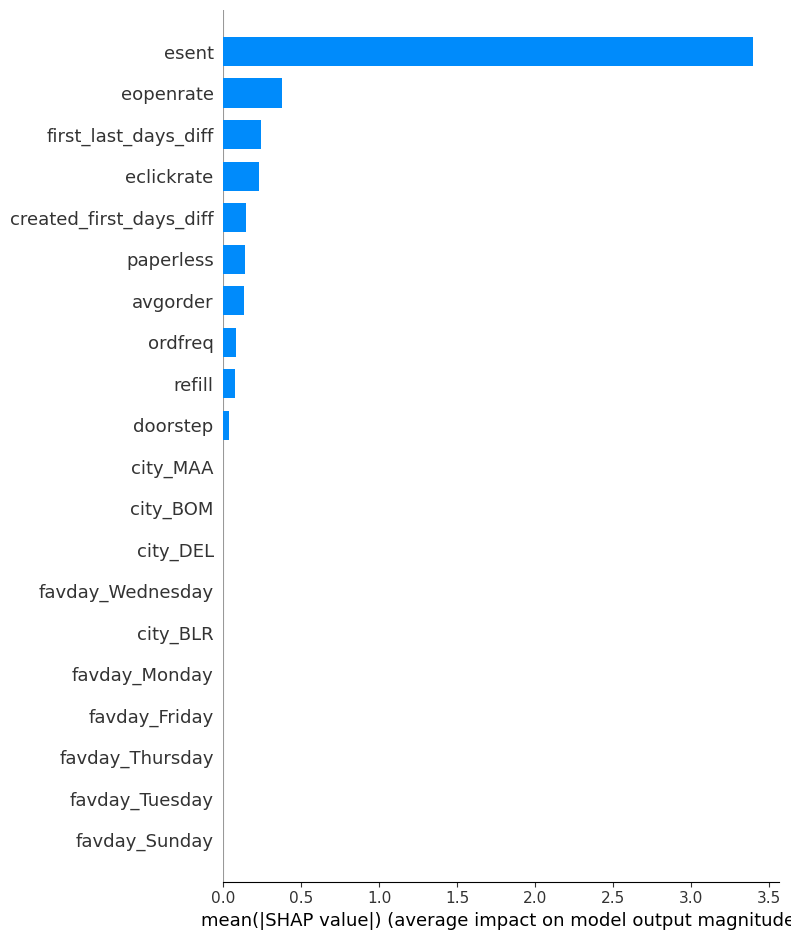

In [ ]:
import shap
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [ ]:
shap_base_value

2.0793018

In [ ]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

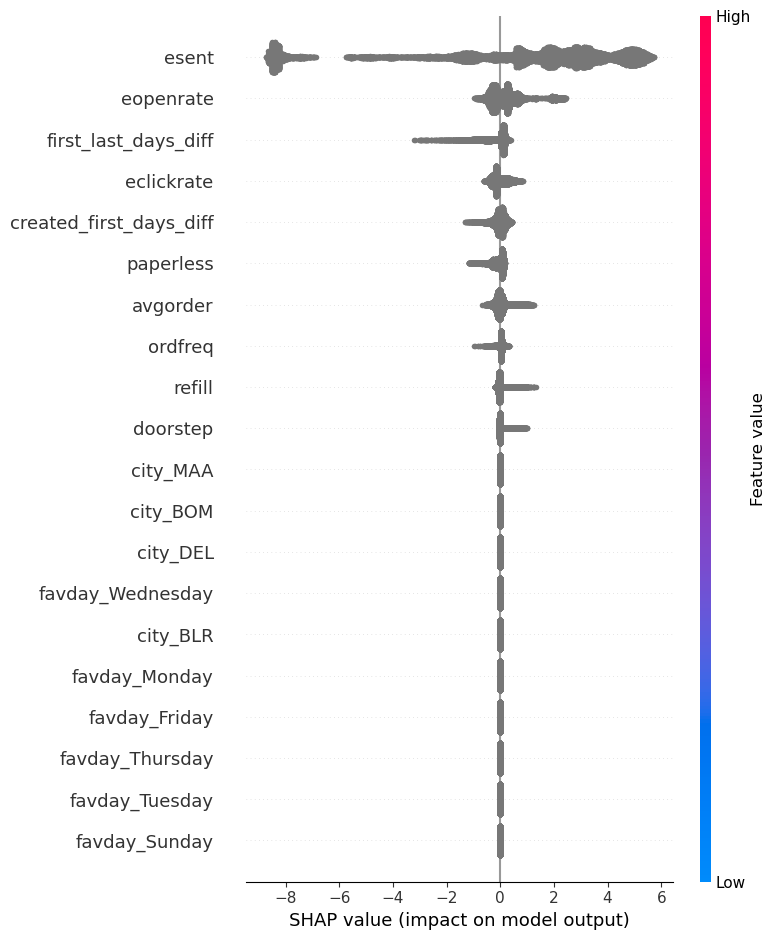

In [ ]:
shap.summary_plot(shap_no_base, train_shap)